In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [2]:
from gensim import models

In [3]:
# Plotting tools
import pyLDAvis

In [4]:
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: Depr

In [5]:
#cleaning and filter the words
import datetime
import sys
import codecs
import re
import urllib, urllib2
import itertools, collections

import nltk  # Natural Language Processing
#nltk.download('punkt')
#nltk.download('all')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords # list of words
from collections import Counter  # optimized way to do this
import string  # list(string.punctuation) - produces a list of punctuations
import copy
from itertools import product, tee, combinations, chain
from nltk.stem import PorterStemmer
from operator import itemgetter # help with dataframes

from scipy.spatial.distance import cosine

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

from time import time

#from tweepy import Stream

encodingTot = sys.stdout.encoding or 'utf-8'

In [6]:
SOME_FIXED_SEED = 42
# before training/inference: 
np.random.seed(SOME_FIXED_SEED)

## 0. Pre-define functions

let predefine some functions and constant to get ready for later processing

In [7]:
# Regex from Gagan ************************************************************

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

# Regex_str is used to GET text from CSV file

regex_str = [
    
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-signs
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)' # other words
]

# These Regex are used to EXCLUDE items from the text AFTER IMPORTING from csv with regex_str

numbers = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
URL = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
html_tag = r'<[^>]+>'
hash_tag = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
at_sign = r'(?:@[\w_]+)'
dash_quote = r"(?:[a-z][a-z'\-_]+[a-z])"
other_word = r'(?:[\w_]+)'
other_stuff = r'(?:\S)' # anything else - NOT USED
start_pound = r"([#?])(\w+)" # Start with #
start_quest_pound = r"(?:^|\s)([#?])(\w+)" # Start with ? or with #
cont_number = r'(\w*\d\w*)' # Words containing numbers

# My REGEX **************************************************************************

#      Remove '[' and ']' brackets

sq_br_f = r'(?:[[\w_]+)' # removes '['
sq_br_b = r'(?:][\w_]+)' # removes ']'

rem_bracket = r'(' + '|'.join([sq_br_f, sq_br_b]) +')'
rem_bracketC = re.compile(rem_bracket, re.VERBOSE)

# Removes all words of 2 characters or less *****************************************************

short_words = r'\W*\b\w{1,2}\b' # Short words of 3 character or less
short_wordsC = re.compile(short_words, re.VERBOSE | re.IGNORECASE)

# REGEX remove all words with \ and / combinations

slash_back =  r'\s*(?:[\w_]*\\(?:[\w_]*\\)*[\w_]*)'
slash_fwd = r'\s*(?:[\w_]*/(?:[\w_]*/)*[\w_]*)'
slash_all = r'\s*(?:[\w_]*[/\\](?:[\w_]*[/\\])*[\w_]*)'

# REGEX numbers, short words and URL only to EXCLUDE +++++++++++++++++++++++++++++++++++++++++++++++++++

num_url_short = r'(' + '|'.join([numbers, URL, short_words + sq_br_f + sq_br_b]) +')'  # Exclude from tweets
comp_num_url_short = re.compile(num_url_short, re.VERBOSE | re.IGNORECASE)

# Master REGEX to INCLUDE from the original tweets ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

list_regex = r'(' + '|'.join(regex_str) + ')'

master_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE) # TAKE from tweets INITIALLY

In [8]:
char_remove = [']', '[', '(', ')', '{', '}'] # characters to be removed

#the other 3character length words will be removed
words_keep = ['old', 'new', 'age', 'lot', 'bag', 'top', 'cat', 'bat', 'sap', 'jda', 'tea', 'dog', 'lie', 'law', 'lab',\
             'mob', 'map', 'car', 'fat', 'sea', 'saw', 'raw', 'rob', 'win', 'can', 'get', 'fan', 'fun', 'big',\
             'use', 'pea', 'pit','pot', 'pat', 'ear', 'eye', 'kit', 'pot', 'pen', 'bud', 'bet', 'god', 'tax', 'won', 'run',\
              'lid', 'log', 'pr', 'pd', 'cop', 'nyc', 'ny', 'la', 'toy', 'war', 'law', 'lax', 'jfk', 'fed', 'cry', 'ceo',\
              'pay', 'pet', 'fan', 'fun', 'usd', 'rio']

emotion_list = [':)', ';)', '(:', '(;', '}', '{','}']


word_garb = ['here', 'there', 'where', 'when', 'would', 'should', 'could','thats', 'youre', 'thanks', 'hasn',\
             'thank', 'https', 'since', 'wanna', 'gonna', 'aint', 'http', 'unto', 'onto', 'into', 'havent',\
             'dont', 'done', 'cant', 'werent', 'https', 'u', 'isnt', 'go', 'theyre', 'each', 'every', 'shes', 'youve', 'youll',\
            'weve', 'theyve']

extra_word_garb = []

#extra_word_garb = ['today','london','greater']

# Dictionary with Replacement Pairs ******************************************************************************
#repl_dict = {'googleele': 'goog', 'lyin': 'lie', 'googles': 'goog', 'aapl':'apple',\
#             'msft':'microsoft', 'google': 'goog', 'googl':'goog'}

repl_dict = {}

exclude = list(string.punctuation) + emotion_list + word_garb + extra_word_garb

# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

stemmer=PorterStemmer()
lmtzr = WordNetLemmatizer()

Prerequisites – Download nltk stopwords and spacy model

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

##### Run in python console
import nltk; nltk.download('stopwords')

##### Run in terminal or command prompt
python3 -m spacy download en

## 1. Prepare Stopwords and basic functions

We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['amp'])

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


def filterPick(list, filter):
    return [ ( l, m.group(1) ) for l in list for m in (filter(l),) if m]



## 2. Load tweets data

first test the methods and then write a loop to auto process all data sets

In [11]:
filename = 'tw_london2017_q2'

In [12]:
directory = 'output/'+ filename + '.csv'
#open tweets 
tw_ori = pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                     error_bad_lines=False,parse_dates=True)


IOError: [Errno 2] No such file or directory: 'output/tw_london2017_q2.csv'

In [206]:
filenames = ['tw_london2017_q2','tw_london2017_q1','tw_london2016_q4','tw_london2016_q3',
             'tw_london2016_q2','tw_london2016_q1','tw_london2015_q4','tw_london2015_q3']

In [207]:
def read_File(filename):
    directory = 'output/'+ filename + '.csv'
    return pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                     error_bad_lines=False,parse_dates=True)

tw_ori = read_File(filenames[0])
print('number of records in file %s is %d' %(filenames[0], len(tw_ori)))

for filename in filenames[1:]:
    df_section = read_File(filename)
    print('number of records in file %s is %d' %(filename, len(df_section)))
    tw_ori = tw_ori.append(df_section)


    

number of records in file tw_london2017_q2 is 234791
number of records in file tw_london2017_q1 is 276929
number of records in file tw_london2016_q4 is 302467
number of records in file tw_london2016_q3 is 351487
number of records in file tw_london2016_q2 is 299470
number of records in file tw_london2016_q1 is 304732
number of records in file tw_london2015_q4 is 286630
number of records in file tw_london2015_q3 is 336700


In [208]:
tw_ori.columns

Index([ u'Unnamed: 0',          u'id',        u'text',      u'userid',
               u'lat',         u'lon',  u'created_at',    u'location',
          u'geometry',        u'time', u'index_right',    u'MSOA11CD',
          u'MSOA11NM',     u'LAD11CD',     u'LAD11NM',     u'RGN11CD',
           u'RGN11NM',    u'USUALRES',    u'HHOLDRES',   u'COMESTRES',
            u'POPDEN',      u'HHOLDS',   u'AVHHOLDSZ'],
      dtype='object')

In [209]:
df = tw_ori[['id','text','userid','lat','lon','created_at','location','geometry','time','MSOA11CD']]

In [210]:
print("number of records is.%s" % str(len(df)))

number of records is.2393206


In [211]:
df = df.sample(int(len(df)*1))
print('remain sample size is %d' %len(df))
print(df.sample(3))

remain sample size is 2393206
                        id                                               text  \
293078  630821981831696384  Looking good... 🍴😋#dinnertime #homemade #eat...   
127392  768762005201248256  I'm at The Rockwell in Kensington  Greater Lon...   
700     716672927652044800  💖 @ Hillsong Church London https://t.co/x4x7M...   

             userid        lat       lon           created_at    location  \
293078   29714469.0  51.437694 -0.054136  2015-08-10 19:24:15    Lewisham   
127392  612565317.0  51.494697 -0.192862  2016-08-25 10:48:39  Kensington   
700     465650502.0  51.514496 -0.140655  2016-04-03 17:05:15      London   

                              geometry          time   MSOA11CD  
293078     POINT (-0.054136 51.437694)  1.439231e+09  E02000673  
127392     POINT (-0.192862 51.494697)  1.472119e+09  E02000589  
700     POINT (-0.14065477 51.5144962)  1.459700e+09  E02000972  


## 3. Preliminary data processing

In [212]:
search_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE).search

import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

# Convert to list
#tweet_list_org = df.text.values.tolist()

tweet_list_org = [str(l).encode('ascii','ignore') for l in df.text]
len(tweet_list_org)

2393206


### Remove hashtag, URL, and at_sign characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [213]:
from time import time

#outlist_init = filterPick(tweet_list_org, search_regex) # It is a tuple: initial list from all tweets in area
outlist_init = tweet_list_org

t0 = time()
outlist_init = [re.sub(URL, "", str(tw_clean)) for tw_clean in outlist_init]
print("URL done in %0.3fs." % (time() - t0))
print("number of records after URL is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(html_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("HTML_TAG done in %0.3fs." % (time() - t0))
print("number of records after HTML_TAG is %0.fs." % len(outlist_init))

t0 = time()
outlist_init = [re.sub(hash_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("hash_tag done in %0.3fs." % (time() - t0))
print("number of records after hash_tag is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(slash_all,"", str(tw_clean)) for tw_clean in outlist_init]
print("slash_all done in %0.3fs." % (time() - t0))
print("number of records after slash_all is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(cont_number, "",str(tw_clean)) for tw_clean in outlist_init]
print("cont_number done in %0.3fs." % (time() - t0))
print("number of records after cont_number is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(numbers, "",str(tw_clean)) for tw_clean in outlist_init]
print("numbers done in %0.3fs." % (time() - t0))
print("number of records after outlist_init is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(start_pound, "",str(tw_clean)) for tw_clean in outlist_init]
print("pound done in %0.3fs." % (time() - t0))
print("number of records after pound is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(start_quest_pound, "",str(tw_clean)) for tw_clean in outlist_init]
print("marks done in %0.3fs." % (time() - t0))
print("number of records after marks is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(at_sign, "",str(tw_clean)) for tw_clean in outlist_init]
print("at_sign done in %0.3fs." % (time() - t0))
print("number of records after at_sign is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub("'", "",str(tw_clean)) for tw_clean in outlist_init]
print("quotation done in %0.3fs." % (time() - t0))
print("number of records after quotation is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub('"', "",str(tw_clean)) for tw_clean in outlist_init]
print("double quotation done in %0.3fs." % (time() - t0))
print("number of records after double is %0.fs." % len(outlist_init))


t0 = time()
# Removes # and @ in words (lookahead)
outlist_init = [re.sub(r'(?:^|\s)[@#].*?(?=[,;:.!?]|\s|$)', r'', tw_clean) for tw_clean in outlist_init] 
print("symbols done in %0.3fs." % (time() - t0))
print("number of records after symbols is %0.fs." % len(outlist_init))

#data = [" ".join(i) for i in outlist_init]
# Removes shortwords
t0 = time()
outlist_init = [re.sub(short_words, "",str(tw_clean)) for tw_clean in outlist_init]
print("remove shortwords done in %0.3fs." % (time() - t0))
print("number of records after shortwords is %0.fs." % len(outlist_init))

pprint(outlist_init[0])
data = outlist_init

URL done in 12.548s.
number of records after URL is 2393206s.
HTML_TAG done in 6.367s.
number of records after HTML_TAG is 2393206s.
hash_tag done in 14.126s.
number of records after hash_tag is 2393206s.
slash_all done in 38.218s.
number of records after slash_all is 2393206s.
cont_number done in 28.051s.
number of records after cont_number is 2393206s.
numbers done in 13.744s.
number of records after outlist_init is 2393206s.
pound done in 8.607s.
number of records after pound is 2393206s.
marks done in 12.560s.
number of records after marks is 2393206s.
at_sign done in 7.679s.
number of records after at_sign is 2393206s.
quotation done in 7.389s.
number of records after quotation is 2393206s.
double quotation done in 5.195s.
number of records after double is 2393206s.
symbols done in 14.868s.
number of records after symbols is 2393206s.
remove shortwords done in 26.036s.
number of records after shortwords is 2393206s.
u' Farringdon Railway Station (ZFD London  Greater London '


In [214]:
len(data)

2393206

After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

## 3. Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [215]:
import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

In [216]:

data_words = list(sent_to_words(data))

print(data_words[0])

[u'farringdon', u'railway', u'station', u'zfd', u'london', u'greater', u'london']


In [173]:
df_test = df
df_test['clean_text_uncombined'] = pd.Series(data).values
df_test.to_csv('clean_text_uncombined_2015q3_2017q3.csv', encoding='utf-8' )

## 4. Creating Bigram and Trigram Models (this is very important)
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘london_bridge’, ‘regent_park’, etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [217]:
#Build the bigram and trigram models

t0 = time()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print("building phrases done in %0.3fs." % (time() - t0))

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

building phrases done in 283.220s.
[u'farringdon', u'railway_station_zfd', u'london', u'greater', u'london']


## 5. Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [219]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_trigrams(data_words_nostops)

In [220]:
from __future__ import unicode_literals
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#nlp = spacy.load('en', disable=['parser', 'ner'])

In [221]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [222]:
# Do lemmatization keeping only noun, adj, vb, adv

t0 = time()
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("lemmatization done in %0.3fs." % (time() - t0))

print(data_lemmatized[0])

lemmatization done in 6162.805s.
[u'farringdon', u'london', u'great', u'london']


In [223]:
data_lemmatized_out = [" ".join(i) for i in data_lemmatized]
data_lemmatized_out = pd.DataFrame(data_lemmatized_out)

In [224]:
df['clean_text'] = pd.Series(data_lemmatized_out.iloc[:,0]).values

In [225]:
df['text'].head(3)

119394    I'm at Farringdon Railway Station (ZFD) - @nat...
191572    Featuring the work of Millennium contributor A...
42236     I'm at @CantinaLaredoUk in Covent Garden  Grea...
Name: text, dtype: object

In [226]:
df['clean_text'].head(3)

119394                       farringdon london great london
191572    feature work_millennium_contributor amelie ber...
42236                            covent_garden great london
Name: clean_text, dtype: object

In [227]:
#to_filename = 'output/cleaned_tw_'+ filename + '.csv'
to_filename = 'output/cleaned_tw_2015_2017_q3.csv'
to_filename
df.to_csv(to_filename, encoding='utf-8' )

In [95]:
#note that you will find out some @ with a space after it means a location. therefore famouse locations were mined out
# and very unluck amp is from &amp --- we have to delete this word - otherwise it makes the thing looks so bad 
data_lemmatized[1:3]

[[[u'feature work_millennium_contributor amelie berton woman']],
 [[u'covent_garden great london']]]

## Read the csv file back

In [11]:
directory = 'output/'+ 'cleaned_tw_2015_2017_q3' + '.csv'
#open tweets 
df = pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                     error_bad_lines=False,parse_dates=True)

remain sample size is 23932
         Unnamed: 0                  id  \
627670       109010  801454171597795329   
2131836      262469  673222952033378305   
968507       228225  744599266799149056   

                                                      text      userid  \
627670   Harryyy (@ Platform 9¾ in King's Cross  Greate...  19310506.0   
2131836  Ditching grease in a bid to make my Hopes even...    817685.0   
968507   Two beautiful #churches in #earlscourt #london...  39027793.0   

               lat       lon           created_at     location  \
627670   51.531974 -0.124184  2016-11-23 15:55:39  Camden Town   
2131836  51.424530  0.008067  2015-12-05 19:30:34     Lewisham   
968507   51.492433 -0.194984  2016-06-19 18:34:33   Kensington   

                                         geometry          time   MSOA11CD  \
627670             POINT (-0.12418364 51.5319738)  1.479917e+09  E02000187   
2131836  POINT (0.008067329999999999 51.42453042)  1.449344e+09  E02006783   
968

In [14]:
#we use 1% sample for quick experiment 
df_clean = df.sample(int(len(df)*0.01))
print('remain sample size is %d' %len(df_clean))
print(df.sample(3))

remain sample size is 23932
         Unnamed: 0                  id  \
739940       238214  800029860676694020   
1034224      227880  777468795388588033   
326357        86048  675665624681586688   

                                                      text       userid  \
739940   Cute picture of the birthday boy @ Good Hope h...  127563669.0   
1034224  We are setting up to sell our #posterzine publ...  334195426.0   
326357   I'm at @CostaCoffee in Lambeth  Greater London...  204527445.0   

               lat       lon           created_at  location  \
739940   51.450685 -0.006069  2016-11-19 17:35:57  Lewisham   
1034224  51.554610 -0.066980  2016-09-18 11:26:20   Hackney   
326357   51.498925 -0.112041  2015-12-12 13:16:52   Lambeth   

                                geometry          time   MSOA11CD  \
739940       POINT (-0.006069 51.450685)  1.479577e+09  E02000669   
1034224      POINT (-0.06698 51.5546099)  1.474194e+09  E02000360   
326357   POINT (-0.11204123 51.4989253

In [15]:
#remove tweets that are shorter than 3 words
df_text = df_clean['clean_text']

def if_short_text(text):
    return len(text.split(' '))>=3

c = df_text.apply(lambda x: if_short_text(str(x)))

In [16]:
df_clean = df_clean[c]

In [17]:
df_clean.sample(3)

Unnamed: 0                  id  \
1536826      330801  756050816688062464   
2291709       13107  632122936388886528   
1567008      103863  765956995954253825   

                                                      text        userid  \
1536826  https://t.co/yCssZ8wZfs. the funniest thing ev...  3.030952e+09   
2291709  Brekkie! (at @BalansLondon in Soho  Greater Lo...  8.010042e+06   
1567008  Wandering round the City. #thisislondon #vscoc...  1.300801e+08   

               lat       lon           created_at        location  \
1536826  51.495670  0.106242  2016-07-21 08:58:56          Eltham   
2291709  51.512826 -0.132464  2015-08-14 09:33:46          London   
1567008  51.516775 -0.090201  2016-08-17 17:02:33  City of London   

                                         geometry          time   MSOA11CD  \
1536826              POINT (0.1062416 51.4956699)  1.469088e+09  E02000315   
2291709               POINT (-0.132464 51.512826)  1.439541e+09  E02000972   
1567008  POINT (-0.09020126000000001 51.51677502)  1.471450e+09  E02000001   

                                         clean_text  
1536826  funniest thing ever definitely worth watch  
2291709                   brekkie soho great london  
1567008                           wander round city

In [18]:
data_lemmatized = list(sent_to_words(df_clean['clean_text']))
data_lemmatized[1:3]

[[u'go',
  u'past',
  u'wembley',
  u'brother',
  u'start',
  u'scream',
  u'actually',
  u'freak'],
 [u'chilly', u'morning', u'london', u'today', u'kew_garden', u'station']]

## OK, if the results seems really weird that we do something 

- remove more key words
- remove some tweets

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_extra_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_extra_words] for doc in texts]
stop_extra_words=[]
stop_extra_words.extend(['amp'])

# Remove Stop Words
data_lemmatized_new = remove_stopwords(data_lemmatized)
print("remove extra words done in %0.3fs." % (time() - t0))

NameError: name 't0' is not defined

## 6. Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [21]:
len(texts)

19218

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [22]:
id2word[0]

u'cook'

In [23]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## 7. Find the optimal number of topics for LDA by coherence

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        t0 = time()
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, iterations = 1200,
                                                 num_topics=num_topics, id2word=id2word)
        print("one model done in %0.3fs." % (time() - t0))
        model_list.append(model)
        t0 = time()
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print("one coherencemodel done in %0.3fs." % (time() - t0))
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=22, step=3)

one model done in 50.100s.
one coherencemodel done in 0.001s.
one model done in 50.440s.
one coherencemodel done in 0.001s.
one model done in 50.895s.
one coherencemodel done in 0.002s.
one model done in 51.422s.
one coherencemodel done in 0.003s.
one model done in 51.617s.
one coherencemodel done in 0.002s.
one model done in 51.281s.
one coherencemodel done in 0.003s.
one model done in 51.451s.
one coherencemodel done in 0.003s.


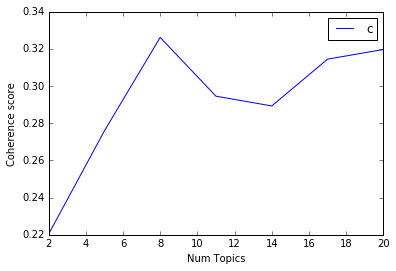

In [37]:
# Show graph
limit=22; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

('Num Topics =', 2, ' has Coherence Value of', 0.2203)
('Num Topics =', 5, ' has Coherence Value of', 0.2758)
('Num Topics =', 8, ' has Coherence Value of', 0.3261)
('Num Topics =', 11, ' has Coherence Value of', 0.2945)
('Num Topics =', 14, ' has Coherence Value of', 0.2893)
('Num Topics =', 17, ' has Coherence Value of', 0.3144)
('Num Topics =', 20, ' has Coherence Value of', 0.3196)


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [43]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  u'0.052*"time" + 0.038*"make" + 0.030*"morning" + 0.028*"back" + 0.016*"life" + 0.014*"coffee" + 0.013*"road" + 0.012*"nice" + 0.012*"christma" + 0.012*"feel"'),
 (1,
  u'0.056*"night" + 0.024*"amazing" + 0.024*"lovely" + 0.024*"drink" + 0.022*"bar" + 0.015*"evening" + 0.015*"food" + 0.015*"dinner" + 0.014*"friday" + 0.013*"place"'),
 (2,
  u'0.381*"london" + 0.184*"great" + 0.015*"city" + 0.013*"hotel" + 0.012*"soho" + 0.007*"england" + 0.006*"east" + 0.006*"railway_station" + 0.006*"covent_garden" + 0.005*"victoria"'),
 (3,
  u'0.077*"day" + 0.063*"today" + 0.037*"work" + 0.018*"home" + 0.015*"people" + 0.014*"beautiful" + 0.013*"team" + 0.013*"lunch" + 0.011*"shoot" + 0.009*"long"'),
 (4,
  u'0.055*"love" + 0.041*"post" + 0.038*"photo" + 0.021*"birthday" + 0.014*"party" + 0.012*"studio" + 0.012*"guy" + 0.011*"check" + 0.009*"art" + 0.008*"centre"'),
 (5,
  u'0.042*"park" + 0.030*"street" + 0.021*"house" + 0.017*"sunday" + 0.016*"big" + 0.014*"club" + 0.012*"saturday" + 0.011*

## 13. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [44]:
def format_topics_sentences(ldamodel, corpus=corpus, texts = data_lemmatized):  #=lda_model #=data
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


t0 = time()
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts= data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
print("Assigning the dominant topic used %0.3fs." % (time() - t0))

Assigning the dominant topic used 75.076s.


In [45]:
len(data_lemmatized)

19218

(array([ 1795.,  2000.,  2683.,  2119.,  2466.,  2431.,  2660.,  3064.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

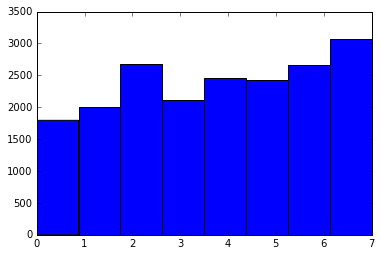

In [46]:
plt.hist(df_dominant_topic['Dominant_Topic'],8)

## 13-2 load saved session back

In [47]:
import dill
dill.dump_session('notebook_env_0607.db')

In [ ]:
import dill
dill.load_session('notebook_env_0607.db')

## 14. Summarise the dominant topic for each zone

In [264]:
import pysal as ps
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

from pysal.contrib.viz import mapping as maps


#wknn5 = ps.weights.KNN.from_shapefile('data/london_msoa.shp', k=10)

In [265]:
df_clean['topic'] = np.array(df_dominant_topic['Dominant_Topic'])
#df_clean.to_csv('data_clean.csv',encoding='utf-8' )

In [266]:
df_count = df_clean.groupby(['MSOA11CD'])['id'].count()
summary = pd.DataFrame(df_clean.groupby(['MSOA11CD', 'topic'])['id'].count())
summary = pd.DataFrame(summary.unstack())
summary.head(3)

id                                            
topic       0.0   1.0    2.0   3.0   4.0   5.0   6.0    7.0
MSOA11CD                                                   
E02000001  77.0  67.0  124.0  64.0  64.0  90.0  83.0  111.0
E02000002   NaN   NaN    NaN   NaN   NaN   NaN   NaN    1.0
E02000003   NaN   NaN    NaN   3.0   NaN   1.0   1.0    2.0

In [267]:
a = range(8) 
a = map(str, a)
colsnames = a + ['MSOA11CD']

In [268]:
df_summary = pd.DataFrame(summary.iloc[:,:].values)
df_summary['MSOA11CD'] = summary.index.values
df_summary.columns = colsnames
df_summary = df_summary.fillna(0)
df_summary['count'] = df_count.values

In [269]:
df_summary.head(3)

0     1      2     3     4     5     6      7   MSOA11CD  count
0  77.0  67.0  124.0  64.0  64.0  90.0  83.0  111.0  E02000001    680
1   0.0   0.0    0.0   0.0   0.0   0.0   0.0    1.0  E02000002      1
2   0.0   0.0    0.0   3.0   0.0   1.0   1.0    2.0  E02000003      7

In [270]:
df_summary.shape

(946, 10)

In [145]:
def getMaxindex(c):
    return c.index(max(c))

In [271]:
df_summary_c = df_summary.iloc[:,0:(df_summary.shape[1]-2)]
#rs = df_summary_c.apply(lambda x: getMaxindex(x.tolist()))
rs = [getMaxindex(row[0:(df_summary.shape[1]-2)].tolist()) for index, row in df_summary_c.iterrows()]
df_summary['dom_topic'] = rs

In [274]:
shp_path = 'data/london_msoa.shp'
data_table = pd.DataFrame(ps.pdio.read_files(shp_path))
data_table.head(3)

MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0  E12000007  London      7375      7187        188    25.5    4385   
1  E12000007  London      6775      6724         51    31.3    2713   
2  E12000007  London     10045     10033         12    46.9    3834   

   AVHHOLDSZ                                         geometry  
0        1.6  <pysal.cg.shapes.Polygon object at 0x1270d24d0>  
1        2.5  <pysal.cg.shapes.Polygon object at 0x1270d2590>  
2        2.6  <pysal.cg.shapes.Polygon object at 0x1270d2610>

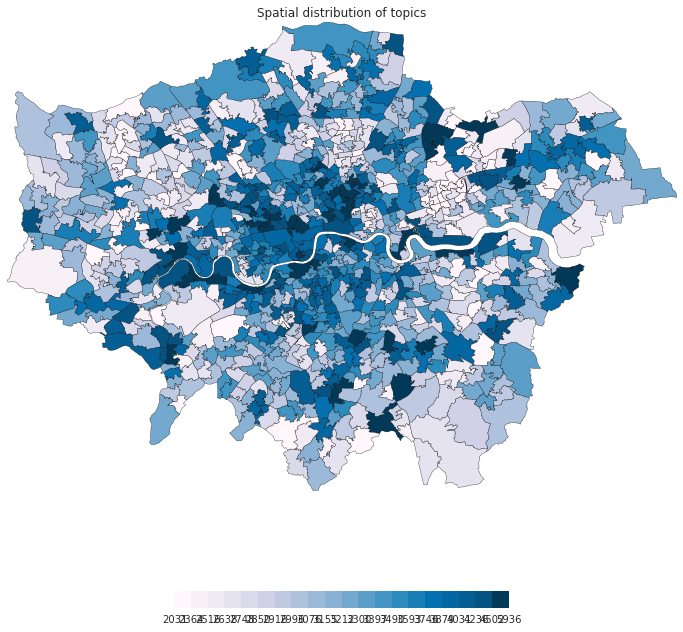

In [348]:
values = pd.Series(test.HHOLDS)
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'quantiles'
maps.plot_choropleth(shp_link, values, types, title='Spatial distribution of topics', 
                     figsize=(12, 12), cmap = 'PuBu',k=20 ,alpha=1)

In [350]:
data_table = data_table.astype('object')
df_summary['MSOA11CD'] = df_summary['MSOA11CD'].astype('object') 
test = pd.merge(data_table, df_summary, on='MSOA11CD', how='outer')
values = test['count'].fillna(0)

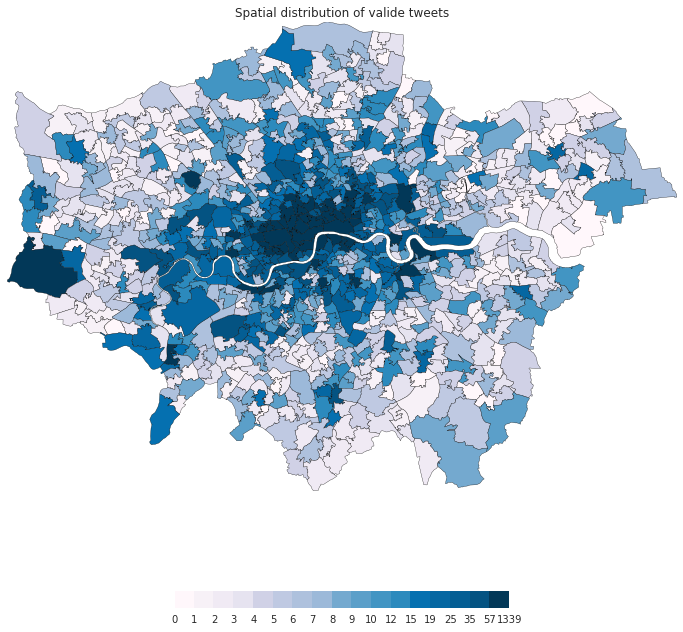

In [351]:
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'quantiles'
maps.plot_choropleth(shp_link, values, types, title='Spatial distribution of valide tweets', 
                     figsize=(12, 12),k=20, cmap='PuBu', alpha=1)

In [352]:
values = test['dom_topic'].fillna(-1)

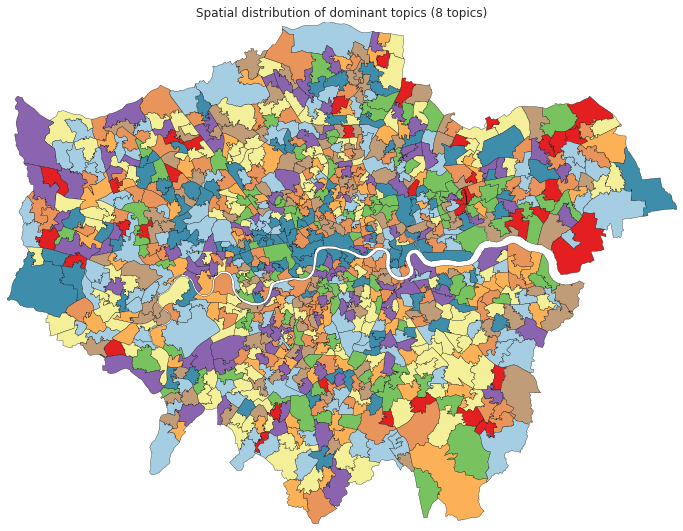

In [353]:
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'unique_values'
maps.plot_choropleth(shp_link, values, types, 
                     title='Spatial distribution of dominant topics (8 topics)', figsize=(12, 9), alpha=1)

## 15. Spatial analysis of distributions of all topics in each zone  

In [283]:
%matplotlib inline

import pysal as ps
import numpy as np
from pysal.contrib.viz import mapping as maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Classic correlation and Spaital bi-vari Moran's I

In [319]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()

In [318]:
to_clu = (test[['0','1','2','3','4','5','6','7']])
for col in to_clu.columns:
    to_clu[col] = to_clu[col]/test['count']

to_clu = to_clu.fillna(0)
to_clu.head(1)

/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0         1         2         3         4         5         6  \
0  0.113235  0.098529  0.182353  0.094118  0.094118  0.132353  0.122059   

          7  
0  0.163235

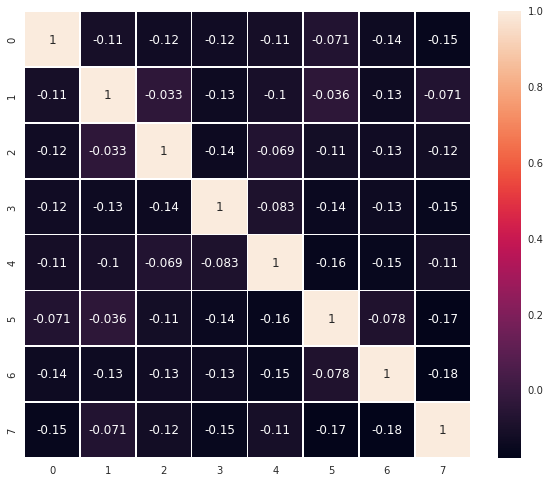

In [320]:
# calculate the correlation matrix
corr = to_clu.corr()

fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)



In [321]:
spatial_corr = np.zeros((8,8), dtype=np.float)
for i in range(8):
    for j in range(8):
        spatial_corr[i,j] = ps.Moran_BV(to_clu.iloc[:,i],  to_clu.iloc[:,j],  w).I

In [323]:
ps.Moran_BV(to_clu.iloc[:,0],  to_clu.iloc[:,0],  w).I

0.020176636716196617

In [327]:
ps.Moran(to_clu.iloc[:,0], w, two_tailed=False).I

0.020176636716196621

The value on the dignal line is the spatial autocorrelation global Moran's I

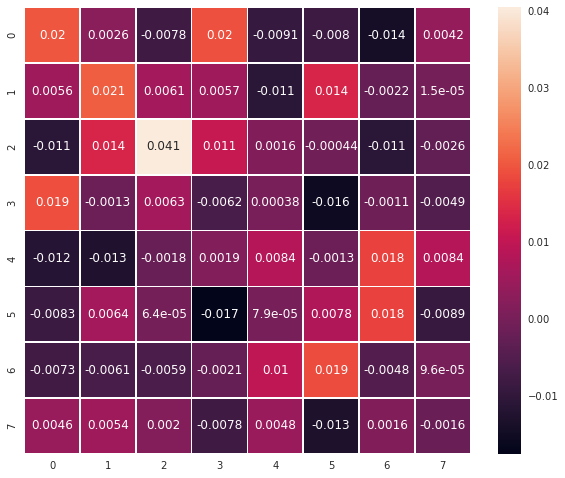

In [322]:
fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
sns.heatmap(spatial_corr, annot=True, linewidths=.5, ax=ax)

### (local moran's I) - LIST to check the distribution of topics

In [284]:
shp_link = 'data/london_msoa.shp'
#w = ps.queen_from_shapefile(shp_link)
w = ps.weights.KNN.from_shapefile(shp_link, k=20)

In [285]:
n_topics = 8
index_topics = range(n_topics)
index_topics[0]

0

In [286]:
import cartopy.crs as ccrs
orig_crs = ccrs.PlateCarree()
projection = ccrs.Mercator()

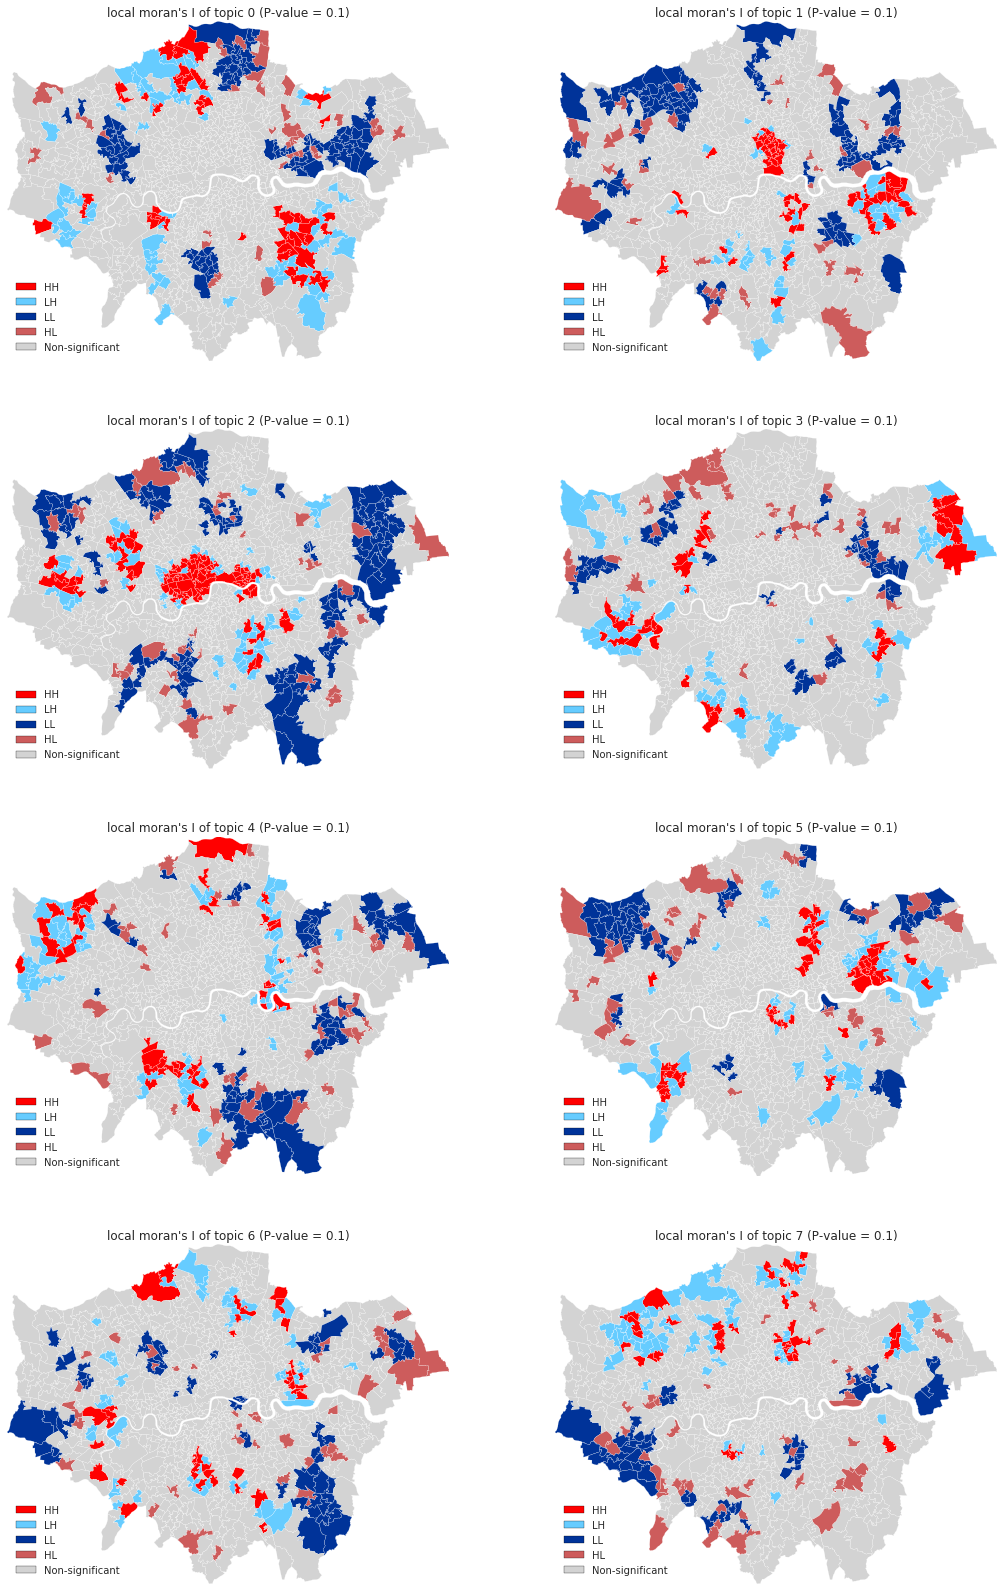

In [302]:
n_topics = 8
index_topics = range(n_topics)

f = plt.figure(figsize=(18, 28))

for i in index_topics:
    values_topic = test[str(i)]/test['count']
    values_topic = values_topic.fillna(0)
    shp = ps.open(shp_link)
    polys = maps.map_poly_shp(shp)
    lisa = ps.Moran_Local(values_topic, w, permutations=9999)
    polys = maps.base_lisa_cluster(polys, lisa, p_thres=0.1)
    polys.set_edgecolor('1')
    polys.set_linewidth(0.2)
    polys.set_transform(orig_crs)

    ax = plt.subplot(4, 2, i+1, projection=projection)
    extent = [shp.bbox[0], shp.bbox[2], shp.bbox[1], shp.bbox[3]]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_collection(polys)
    ax.outline_patch.set_visible(False)

    boxes, labels = maps.lisa_legend_components(lisa, p_thres=0.1)
    plt.legend(boxes, labels, loc='lower left', frameon=False)
    ax.set_title('local moran\'s I of topic %d (P-value = 0.1)' %i)

plt.show()

## 15. Summarising topics by k-means clustering

Ok, so the topics are distributed everywhere but still concentrated in certain zones that are not globally clustered together. - which indicates low spaital segregation of topics/functions. But still we'd like to see if there is any structures hidden in the distribution. so what we do here are:

1 - K-means clustering

2 - mean-shift clustering

3 - spatially constraint multi-variable clustering


In [287]:
to_clu = test[['0','1','2','3','4','5','6','7']]
to_clu = to_clu.fillna(0)

### k-mean clustering

In [354]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array(to_clu)
kmeans = KMeans(n_clusters=10, max_iter = 1000).fit(X)
values = pd.Series(kmeans.labels_)
test['k_mean_20'] = pd.Series(kmeans.labels_).values

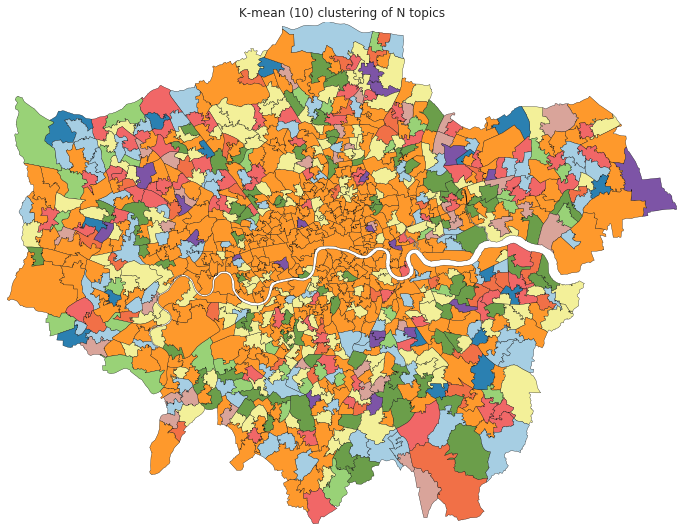

In [355]:
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'unique_values'
maps.plot_choropleth(shp_link, values, types, title='K-mean (10) clustering of N topics', 
                     figsize=(12, 9), alpha = 1)


### meanshift clustering

In [337]:
print(__doc__)

import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
test['meanshift'] = pd.Series(ms.labels_).values

Automatically created module for IPython interactive environment


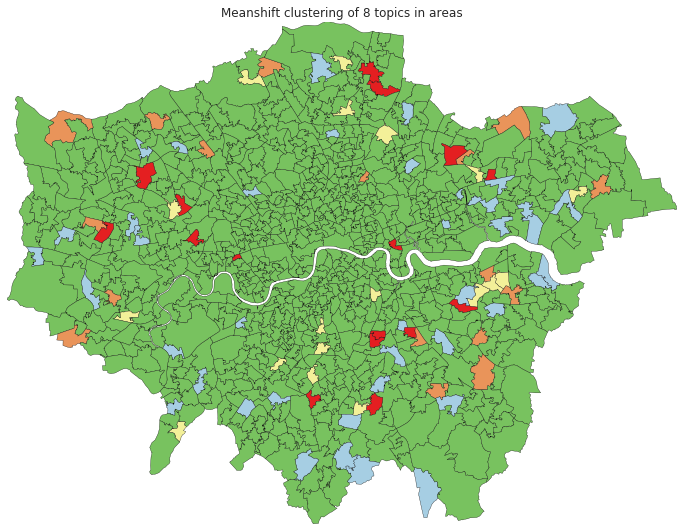

In [338]:
values = pd.Series(labels)
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'unique_values'
maps.plot_choropleth(shp_link, values, types, title='Meanshift clustering of 8 topics in areas', 
                     figsize=(12, 9),alpha = 1)

### Spatially Constrained Hierarchical clustering

In [339]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from scipy.sparse import csr_matrix
import scipy

In [340]:
X = to_clu

In [341]:
w = ps.weights.KNN.from_shapefile(shp_link, k=20)
wsp = ps.weights.WSP(w.sparse)
knn_graph = wsp.sparse
knn_graph = wsp.sparse
connectivity = knn_graph

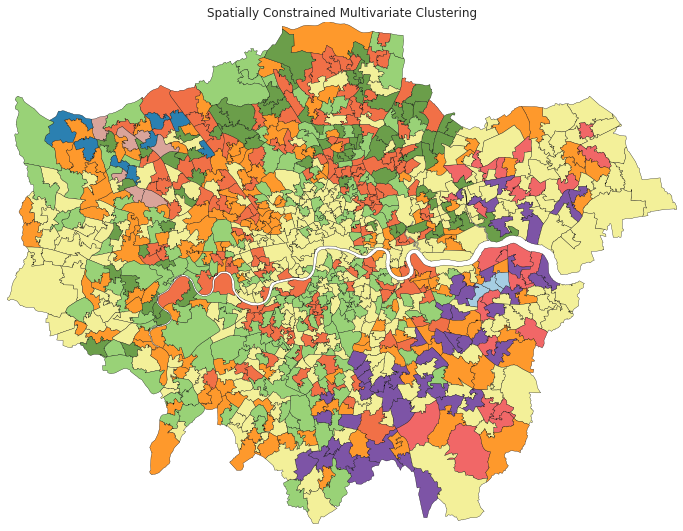

In [356]:
n_clusters = 10
linkage = 'ward'
model = AgglomerativeClustering(linkage=linkage,
                                connectivity=connectivity,
                                n_clusters=n_clusters)
#t0 = time()
model.fit(X)
test['sp_knn20'] = pd.Series(model.labels_).values
#print("multivariables clustering used %0.3fs." % (time() - t0))

values = pd.Series(model.labels_)
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'unique_values'
maps.plot_choropleth(shp_link, values, types, title='Spatially Constrained Multivariate Clustering', 
                     figsize=(12, 9), alpha =1)# cmap = 'Set2'

In [176]:
test.fillna(0).to_csv('rs1.csv', encoding='utf-8' )

## 16. Interpreting topics by spatial measures 

Ok, so the topic does not domain any zones,  that means everyone is talking about everything in any zones

what do we do there:

1- try multi-variable spatial clustering
2- measureing spatial segregation 

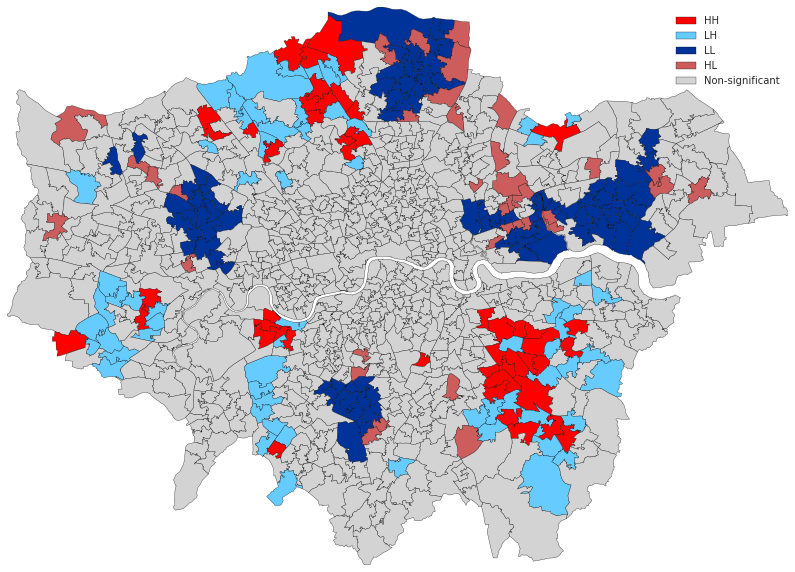

In [182]:
values_topic = test['0']/test['count']
values_topic = values_topic.fillna(0)
lisa = ps.Moran_Local(values_topic, w, permutations=9999)
_ = maps.plot_lisa_cluster(shp_link, lisa, figsize=(14, 10) , p_thres=0.1)

## 19. Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [92]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.7916   
1        1.0              0.6804   
2        2.0              0.7038   
3        3.0              0.6564   
4        4.0              0.7265   

                                            Keywords  \
0  park, today, amp, love, day, make, work, morni...   
1  day, greenwich, great, today, good, time, park...   
2  london, great, amp, good, paddington, day, tim...   
3  day, today, morning, amp, good, love, time, se...   
4  amp, day, night, good, today, drink, tonight, ...   

                                                Text  
0  ( Thats pretty awful. Such shame there are man...  
1  (Active year        These two terrors cleotyso...  
2  ( Source:  Tower Bridge twilight James. Petts ...  
3  (Another Year  Another Opportunity        Chec...  
4  (This awesome! Cheers   Good weekend starts wi...

The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.



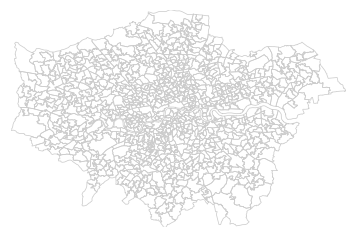

In [139]:
fig = plt.figure()

base = maps.map_poly_shp(shp)
base.set_facecolor('none')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')

ax = maps.setup_ax([base], [shp.bbox, shp.bbox, shp.bbox])
fig.add_axes(ax)
plt.show()

## 20. Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [140]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

TypeError: cannot convert the series to <type 'float'>

## 21. Conclusion

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

## 7. Building the Topic Model using gensim

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [534]:
# Build LDA model
t0 = time()

lda_model_10_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=50,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
print("Topic model building done in %0.3fs." % (time() - t0))

Topic model building done in 2120.718s.


## 7. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

https://anoopacademia.wordpress.com/2015/01/18/install-mallet-on-windows-operating-system/

In [24]:
#import tempfile
#import os 
#os.environ.update({'MALLET_HOME':r'F:/workspace/python/mallet-2.0.8/'})


In [25]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'F:/workspace/python/mallet-2.0.8/bin/mallet' # update this path

mallet_path = '/Users/chenzhong/mallet-2.0.7/bin/mallet' # update this path

In [37]:
# Build LDA model
t0 = time()
print('started at %0.3f' %t0)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, num_topics=10, 
                                              id2word=id2word) #iterations = 500,
print("Topic model building using mallet done in %0.3fs." % (time() - t0))

started at 1530878620.228
Topic model building using mallet done in 44.008s.


In [28]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [(u'day', 0.099492177),
   (u'today', 0.074826404),
   (u'lovely', 0.027360348),
   (u'sunday', 0.02010571),
   (u'big', 0.019483885),
   (u'ready', 0.018032957),
   (u'team', 0.016892942),
   (u'breakfast', 0.013576536),
   (u'bad', 0.010985594),
   (u'hot', 0.0086019272)]),
 (1,
  [(u'street', 0.039288756),
   (u'coffee', 0.019378195),
   (u'find', 0.016396934),
   (u'thing', 0.015545145),
   (u'perfect', 0.013522146),
   (u'favourite', 0.013415673),
   (u'road', 0.012776831),
   (u'summer', 0.011286201),
   (u'food', 0.011179728),
   (u'high', 0.010966781)]),
 (2,
  [(u'park', 0.05568881),
   (u'morning', 0.038585879),
   (u'beautiful', 0.025654396),
   (u'lunch', 0.02419439),
   (u'end', 0.014912921),
   (u'set', 0.014287204),
   (u'view', 0.013244342),
   (u'world', 0.013140056),
   (u'market', 0.012305767),
   (u'run', 0.011471477)]),
 (3,
  [(u'good', 0.065615989),
   (u'night', 0.062319737),
   (u'happy', 0.037597857),
   (u'year', 0.030181294),
   (u'drink', 0.02935723)

## 8. View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [29]:
# Print the Keyword in the 10 topics
pprint(ldamallet.print_topics())
doc_lda = ldamallet[corpus]

[(0,
  u'0.099*"day" + 0.075*"today" + 0.027*"lovely" + 0.020*"sunday" + 0.019*"big" + 0.018*"ready" + 0.017*"team" + 0.014*"breakfast" + 0.011*"bad" + 0.009*"hot"'),
 (1,
  u'0.039*"street" + 0.019*"coffee" + 0.016*"find" + 0.016*"thing" + 0.014*"perfect" + 0.013*"favourite" + 0.013*"road" + 0.011*"summer" + 0.011*"food" + 0.011*"high"'),
 (2,
  u'0.056*"park" + 0.039*"morning" + 0.026*"beautiful" + 0.024*"lunch" + 0.015*"end" + 0.014*"set" + 0.013*"view" + 0.013*"world" + 0.012*"market" + 0.011*"run"'),
 (3,
  u'0.066*"good" + 0.062*"night" + 0.038*"happy" + 0.030*"year" + 0.029*"drink" + 0.027*"birthday" + 0.018*"evening" + 0.017*"friday" + 0.015*"saturday" + 0.012*"beer"'),
 (4,
  u'0.063*"time" + 0.047*"work" + 0.044*"make" + 0.029*"amazing" + 0.025*"show" + 0.015*"christma" + 0.015*"nice" + 0.013*"open" + 0.013*"tomorrow" + 0.013*"book"'),
 (5,
  u'0.068*"love" + 0.054*"photo" + 0.054*"post" + 0.023*"home" + 0.018*"life" + 0.012*"station" + 0.011*"visit" + 0.011*"wait" + 0.010*"c

How to interpret this?

The weights reflect how important a keyword is to that topic.

We can go through the remaining topic keywords and judge what the topic is.

## 9. Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [31]:
import gensim    
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

('\nPerplexity: ', -12.568959667911006)
('\nCoherence Score: ', 0.43186370970916066)


## 10. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      10.053025        1       1  0.000386 -0.000358
8      10.041275        1       2  0.000684  0.000458
0      10.025696        1       3 -0.000017 -0.000408
3      10.010841        1       4 -0.000260  0.000711
7      10.009204        1       5 -0.000165 -0.000250
6      10.000097        1       6  0.000326  0.000515
2       9.991984        1       7 -0.000188  0.000044
1       9.981644        1       8  0.000112  0.000228
5       9.974091        1       9 -0.001149 -0.000022
9       9.912142        1      10  0.000272 -0.000918, topic_info=      Category      Freq             Term     Total  loglift  logprob
term                                                                 
6020   Default  5.000000              bpp  5.000000  30.0000  30.0000
9311   Default  5.000000       andrewtuck  5.000000  29.0000  29.0000
7283   Default  5.000000             evde  5.000000  28.0000  28.0000
4805   Default  5.000000           symbol  5.000000  27.0000  27.0000
13096  Default  5.000000          amorino  5.000000  26.0000  26.0000
2612   Default  5.000000       john_astor  5.000000  25.0000  25.0000
16428  Default  5.000000      gingerbread  5.000000  24.0000  24.0000
7546   Default  5.000000            yhank  5.000000  23.0000  23.0000
2168   Default  5.000000              vrt  5.000000  22.0000  22.0000
10209  Default  6.000000       free_entry  6.000000  21.0000  21.0000
8871   Default  5.000000           cheeky  5.000000  20.0000  20.0000
4381   Default  5.000000            bring  5.000000  19.0000  19.0000
16942  Default  5.000000              pog  5.000000  18.0000  18.0000
17867  Default  5.000000           clapto  5.000000  17.0000  17.0000
14358  Default  5.000000        intensity  5.000000  16.0000  16.0000
19212  Default  5.000000       google_map  5.000000  15.0000  15.0000
1323   Default  5.000000        spiritual  5.000000  14.0000  14.0000
16197  Default  6.000000             porn  6.000000  13.0000  13.0000
4351   Default  5.000000             visa  5.000000  12.0000  12.0000
19316  Default  5.000000        faithless  5.000000  11.0000  11.0000
19610  Default  5.000000        lansdowne  5.000000  10.0000  10.0000
6664   Default  5.000000       megaformer  5.000000   9.0000   9.0000
401    Default  5.000000              smh  5.000000   8.0000   8.0000
4881   Default  5.000000          pairing  5.000000   7.0000   7.0000
16081  Default  5.000000     fstentrinity  5.000000   6.0000   6.0000
16015  Default  5.000000             icmp  5.000000   5.0000   5.0000
270    Default  5.000000       wholewheat  5.000000   4.0000   4.0000
431    Default  5.000000            dayum  5.000000   3.0000   3.0000
4051   Default  5.000000      mixed_grill  5.000000   2.0000   2.0000
13881  Default  5.000000          account  5.000000   1.0000   1.0000
...        ...       ...              ...       ...      ...      ...
6765   Topic10  0.734021        refresher  5.767040   0.2500  -9.6142
3894   Topic10  0.686013     signor_sassi  5.410712   0.2462  -9.6818
13771  Topic10  0.724478         joyabyjy  5.721532   0.2449  -9.6273
13444  Topic10  0.680525             snog  5.374730   0.2448  -9.6899
19610  Topic10  0.722642        lansdowne  5.708461   0.2446  -9.6298
15850  Topic10  0.697563           ninjas  5.513022   0.2441  -9.6651
6270   Topic10  0.695774        certainly  5.506307   0.2428  -9.6677
12289  Topic10  0.711916            tease  5.642728   0.2412  -9.6448
18517  Topic10  0.701508            siglo  5.567935   0.2399  -9.6595
10106  Topic10  0.684657            mooch  5.434972   0.2397  -9.6838
12619  Topic10  0.692988           brolin  5.506223   0.2388  -9.6717
5853   Topic10  0.713306              ail  5.669289   0.2385  -9.6428
19282  Topic10  0.707026  villandry_grand  5.635698   0.2356  -9.6517
4016   Topic10  0.710752            delay  5.668053   0.2351  -9.6464
16638  Topic10  0.6

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.